# Lazy & distributed computing with Dask: a regridding example

## Lazy computation

Using xarray and Dask it is possible to perform computations "lazily". Lazy computation is when you only load data and perform the computations once it is required.

For example, let's define two functions, and apply these to `x`:
```py
def inc(i):
    return i + 1

def add(a, b):
    return a + b

x = 1
y = inc(x)
z = add(y, 10)
```

From these operations, Dask will create a so-called 'task graph' that stores which operations need to be performed on `x`:

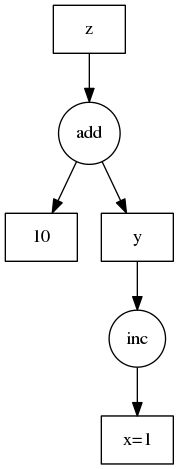

Only once you specifically ask for the result will Dask execute the graph and return the result:
```py
z.compute()
```


*Example code and image originate from the [Dask documentation](https://docs.dask.org/en/latest/graphs.html#example), Copyright (c) 2014, Anaconda, Inc. and contributors*

We can actually run this example if we tell Dask to delay the execution. 

In [1]:
import dask

@dask.delayed
def inc(i):
    return i + 1

@dask.delayed
def add(a, b):
    return a + b

x = 1
y = inc(x)
z = add(y, 10)
z  # returns 'delayed' object

Delayed('add-e0bc38ad-3a1c-4827-bed1-db5ff641b174')

We can compute the result by calling `.compute()`:

In [2]:
z.compute()

12

## Distributed computing

Dask also allows distributed computing of tasks. Tasks will be distributed over multiple cores, and the results aggregated.
This allows you to relatively easily speed up computations.

The computations can be spread over local cores, but can also be performed on cloud infrastructure instead.

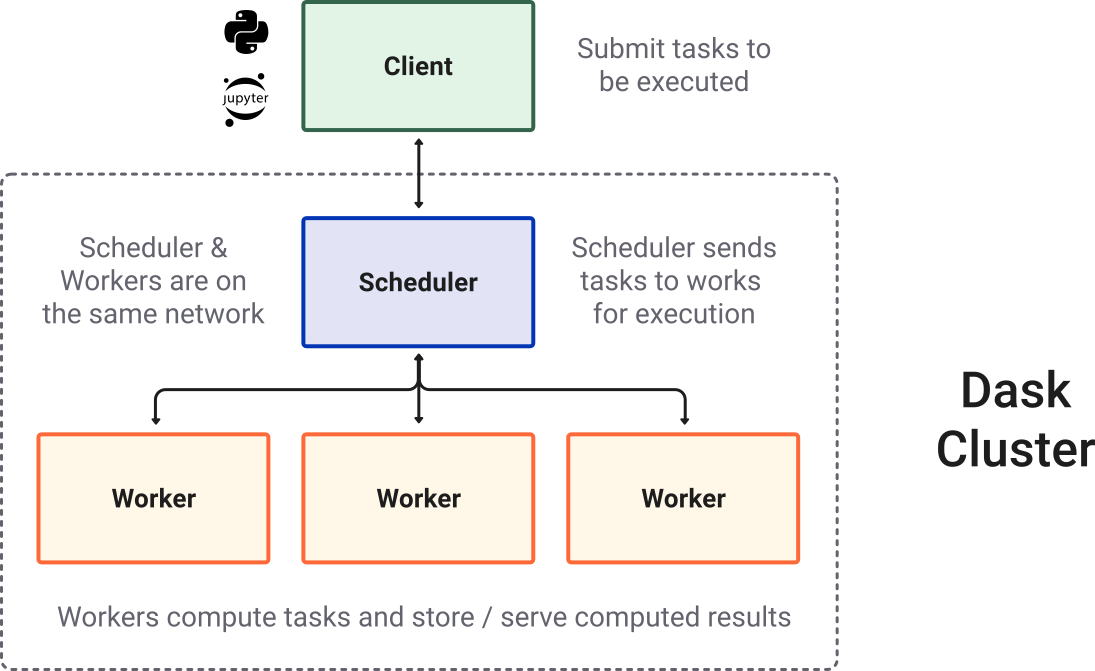

*Image originates from the [Dask documentation](https://tutorial.dask.org/00_overview.html), Copyright (c) 2014, Anaconda, Inc. and contributors*

In [3]:
import dask.distributed

client = dask.distributed.Client() # You can also connect to a remote/cloud server here instead
client  # Show the client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.33 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42319,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.33 GiB
Comm: tcp://127.0.0.1:38465,Total threads: 2
Dashboard: http://127.0.0.1:45281/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:43675,


## Regridding example

Projecting data on different grids is a common operation in geosciences.
The original data might be of a too high resolution to work with, or you are collecting data from multiple sources and need a common grid to compare or aggregate them.

In the [EXCITED project](https://research-software-directory.org/projects/excited) we developed a tool for this to perform regridding in xarray. The tool can make full use of Dask.

### Sea surface temperature dataset

In this example we'll use a sea surface temperature (SST) dataset, which is available at a very high resolution:

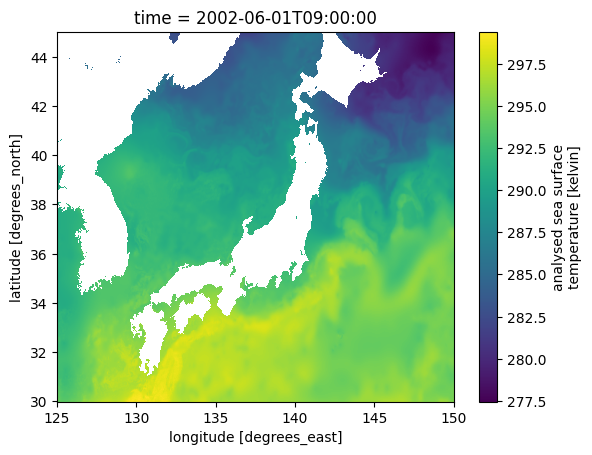

In [4]:
import xarray as xr
import xarray_regrid

sst = xr.open_zarr("https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1")["analysed_sst"]

# Reduce size of array by only selecting a slice
sst.sel(lat=slice(30, 45), lon=slice(125, 150)).isel(time=0).plot()

Note that the full DataArray contains 30 terabytes (!) of data:

In [5]:
sst

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 17999, lon: 36000)> Size: 33TB
dask.array<open_dataset-analysed_sst, shape=(6443, 17999, 36000), dtype=float64, chunksize=(5, 1799, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 52kB 2002-06-01T09:00:00 ... 2020-01-20T09...
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

### Regridding lazily

We can define a new grid, this time at a lower resolution to match other datasets (e.g. ERA5).
We can also define the spatial bounds of this new grid:

In [6]:
import xarray_regrid

target = xarray_regrid.Grid(
    north=45,
    south=30,
    west=125,
    east=150,
    resolution_lat=0.25,
    resolution_lon=0.25,
).create_regridding_dataset(lat_name="lat", lon_name="lon")

With this target grid we can regrid the data. Running it will only take a few seconds, however, no computations are performed yet.

Dask will store the regridding operation, and regridding will only be applied to the (required) data afterwards:

In [7]:
# use a binning strategy, taking the mean of the bins
sst_regrid = sst.regrid.stat(target, method="mean")

In [8]:
sst_regrid  # note that the new object has a much lower resolution, but is not computed yet

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 61, lon: 101)> Size: 318MB
dask.array<where, shape=(6443, 61, 101), dtype=float64, chunksize=(5, 61, 101), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 52kB 2002-06-01T09:00:00 ... 2020-01-20T09...
  * lat      (lat) float64 488B 30.0 30.25 30.5 30.75 ... 44.25 44.5 44.75 45.0
  * lon      (lon) float64 808B 125.0 125.2 125.5 125.8 ... 149.5 149.8 150.0
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

Only once the following cell is run, will the regridding operation be performed on this slice of data.

Dask will automatically spread the computation over multiple cores.

/home/bart/git/workshop_tutorial/.venv/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 30.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


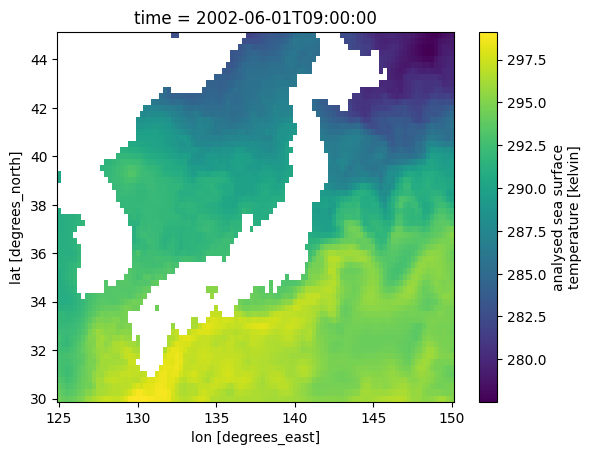

In [9]:
sst_regrid.isel(time=0).plot()